In [61]:
import os
import numpy as np

import openslide
from PIL import Image
import matplotlib.pyplot as plt 
from utils import parse_patch_size, plot_oneline
from utils import get_TC, get_TC1024, run_TC_one_slide
from utils import get_json_from_map
from utils import process_TCmask, bbx_overlay, get_roi_ids, show_roi
from utils import save_patchcsv, get_json_from_ROI

from utils import show_patch


from utils import get_GAPCAM, get_gradCAM

### WSI, foreground tissue mask visualisation

579


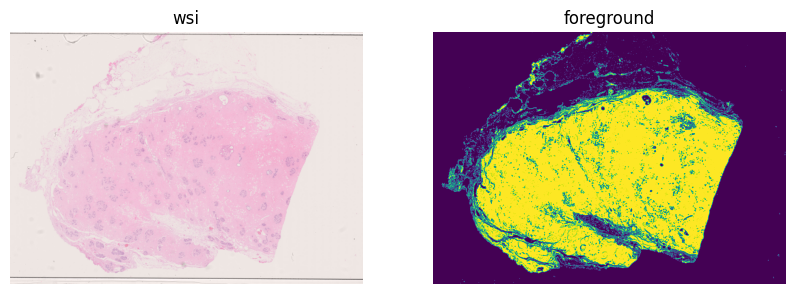

In [5]:
# original WSI
wsi_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17064108_FPE_1.ndpi'
mask_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSI_QC/KHP_RM/17064108_FPE_1.ndpi/17064108_FPE_1.ndpi_mask_use.png'
wsi = openslide.OpenSlide(wsi_pt)
im_wsi = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
patch_size, _ = parse_patch_size(wsi, patch_size=128)
print(patch_size)
# foreground tissue mask generated by HistoQC
im_mask = Image.open(mask_pt)

# plot
plot_oneline([im_wsi, im_mask], ['wsi', 'foreground'], (10,10))

### Run TC_512

In [ ]:
# get TC_512
weights = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/ckpts/Tissue_Classifier.h5'
TC_512 = get_TC(weights)

(-0.5, 271.5, 193.5, -0.5)

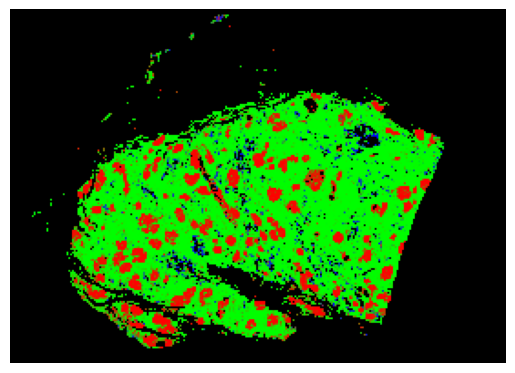

In [42]:
# tissue classification and visualisation 
tissue_map512 = run_TC_one_slide(wsi, mask_pt, TC_512, outputDir, patch_size=128, foreground_thes=0.7)
TC_maskpt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_TCprobmask.npy'
np.save(TC_maskpt, tissue_map)
plt.imshow(tissue_map512)
plt.axis('off')

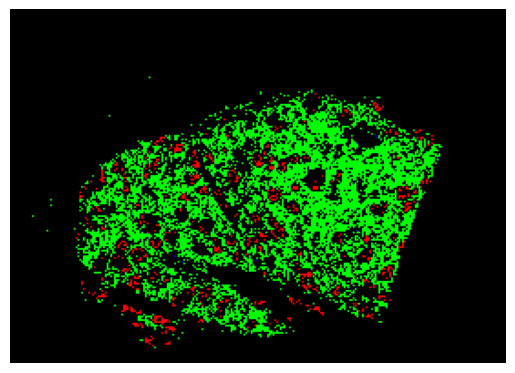

In [76]:
TC_pred = tissue_map512.copy()
TC_pred[:,:, 0][TC_pred[:,:, 0] < 0.99] = 0
TC_pred[:,:, 1][TC_pred[:,:, 1] < 0.99] = 0
TC_pred[:,:, 2][TC_pred[:,:, 2] < 0.99] = 0

plt.imshow(TC_pred)
plt.axis('off')
plt.savefig(f"{outputDir}/{wsi_id}_thres99.png", pad_inches=0, bbox_inches="tight")

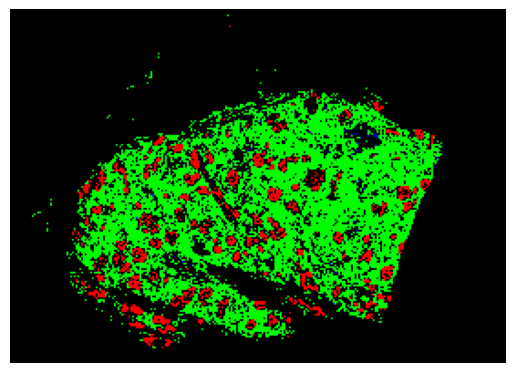

In [75]:
TC_pred = tissue_map512.copy()
TC_pred[:,:, 0][TC_pred[:,:, 0] < 0.95] = 0
TC_pred[:,:, 1][TC_pred[:,:, 1] < 0.95] = 0
TC_pred[:,:, 2][TC_pred[:,:, 2] < 0.95] = 0

plt.imshow(TC_pred)
plt.axis('off')
plt.savefig(f"{outputDir}/{wsi_id}_thres95.png", pad_inches=0, bbox_inches="tight")

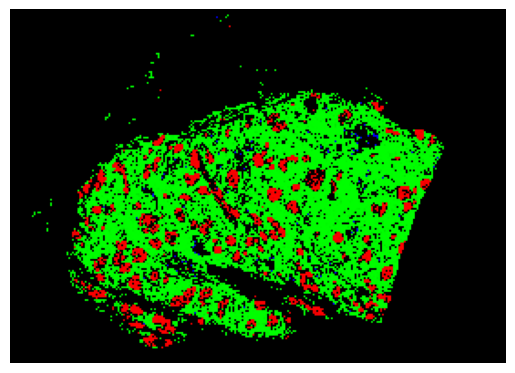

In [74]:
TC_pred = tissue_map512.copy()
TC_pred[:,:, 0][TC_pred[:,:, 0] < 0.9] = 0
TC_pred[:,:, 1][TC_pred[:,:, 1] < 0.9] = 0
TC_pred[:,:, 2][TC_pred[:,:, 2] < 0.9] = 0

plt.imshow(TC_pred)
plt.axis('off')
plt.savefig(f"{outputDir}/{wsi_id}_thres90.png", pad_inches=0, bbox_inches="tight")

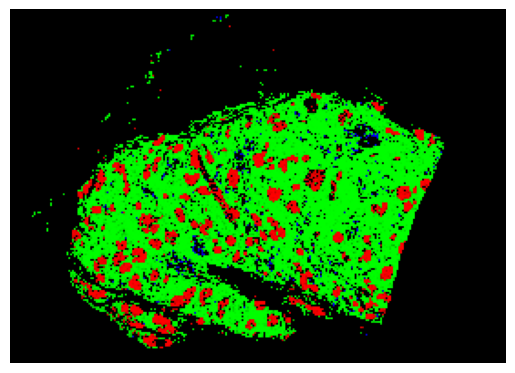

In [73]:
TC_pred = tissue_map512.copy()
TC_pred[:,:, 0][TC_pred[:,:, 0] < 0.7] = 0
TC_pred[:,:, 1][TC_pred[:,:, 1] < 0.7] = 0
TC_pred[:,:, 2][TC_pred[:,:, 2] < 0.7] = 0

plt.imshow(TC_pred)
plt.axis('off')
plt.savefig(f"{outputDir}/{wsi_id}_thres70.png", pad_inches=0, bbox_inches="tight")

### export json file to visualise TC512 results in QuPath

In [43]:
TC_pred = tissue_map512
TC_cls = np.argmax(TC_pred, axis=2)
TC_cls[TC_pred[:,:,0]==0] = 3

cls_dict = {'epithelium': 0, 'stroma':1, 'adipocytes':2, 'background': 3}
json_pt = f"{outputDir}/{wsi_id}_TC512.json"
patch_size, _ = parse_patch_size(wsi, patch_size=128)
print(patch_size)

TC512_json = get_json_from_map(TC_cls, cls_dict, json_pt, patch_size, require_bounds=False)

579
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/17064108_FPE_1_TC512.json saved!


## ROI detection (optional)

(-0.5, 8703.5, 6207.5, -0.5)

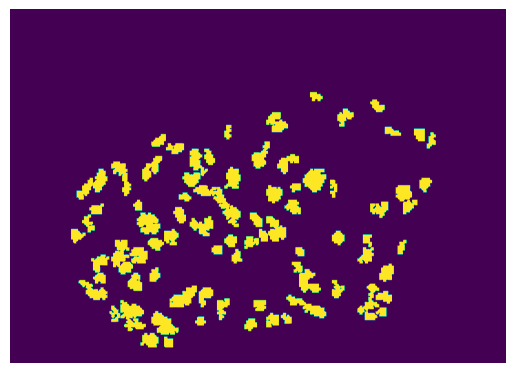

In [14]:
upsample=32
small_objects=400000
roi_width=250

TC_maskpt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_TCprobmask.npy'
epi_mask, roi_width, wsi_mask_ratio = process_TCmask(wsi_pt, TC_maskpt, upsample, small_objects, roi_width)
plt.imshow(epi_mask)
plt.axis('off')

(-0.5, 8703.5, 6207.5, -0.5)

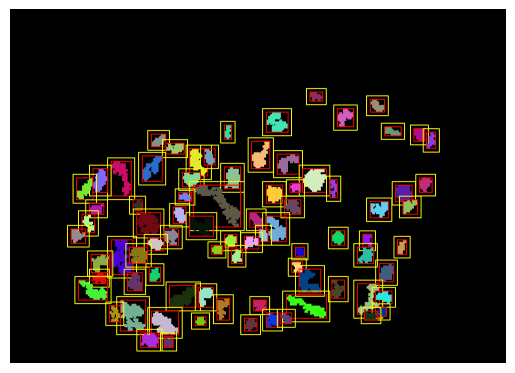

In [18]:
wsi_id = os.path.basename(wsi_pt).split('.')[0]
bbx_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_bbx.png'
bbx_map = bbx_overlay(epi_mask=epi_mask, overlay_pt=bbx_pt, roi_width=roi_width) 

plt.imshow(bbx_map)
plt.axis('off')

In [20]:
roi_ids = get_roi_ids(epi_mask, wsi_id, roi_width, upsample, wsi_mask_ratio)

There're 81 ROIs detected


(-0.5, 9184.5, 8604.5, -0.5)

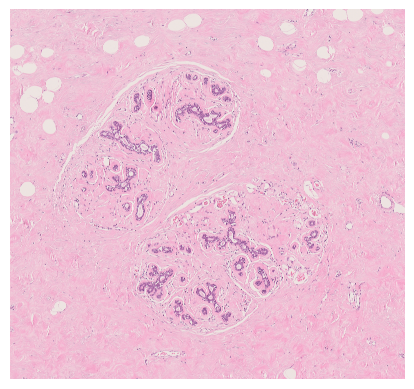

In [22]:
im = show_roi(wsi, roi_ids[3])
plt.imshow(im)
plt.axis('off')

In [26]:
patch_size, _ = parse_patch_size(wsi, patch_size=128)
print(patch_size)

    
patch_df = save_patchcsv(roi_ids, patch_size, TC_maskpt, output_dir='/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/')
patch_df['sum'] = patch_df.iloc[:, 3:6].sum(axis=1)
patch_df = patch_df.loc[patch_df['sum'] != 0.0]
patch_df.head()

579
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1//_patch.csv saved!


roi_id  \
30  17064108_FPE_1_94248_25256_6286_5127   
31  17064108_FPE_1_94248_25256_6286_5127   
32  17064108_FPE_1_94248_25256_6286_5127   
33  17064108_FPE_1_94248_25256_6286_5127   
34  17064108_FPE_1_94248_25256_6286_5127   

                                           patch_id         cls    TC_epi  \
30  17064108_FPE_1_94248_25256_6286_5127_165_46_579  epithelium  0.961740   
31  17064108_FPE_1_94248_25256_6286_5127_166_46_579  epithelium  0.877535   
32  17064108_FPE_1_94248_25256_6286_5127_167_46_579  epithelium  0.990325   
33  17064108_FPE_1_94248_25256_6286_5127_165_47_579  epithelium  0.966942   
34  17064108_FPE_1_94248_25256_6286_5127_166_47_579  epithelium  0.947463   

      TC_str    TC_adi cohort wsi_id  sum  
30  0.038243  0.000017                1.0  
31  0.122368  0.000097                1.0  
32  0.009652  0.000023                1.0  
33  0.033001  0.000057                1.0  
34  0.052334  0.000204                1.0

In [29]:
cls_dict = {'epithelium': 0, 'stroma':1, 'adipocytes':2, 'background': 3}
json_pt = f"/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1//{wsi_id}_TC512_ROIdetection.json"

get_json_from_ROI(patch_df, cls_dict, patch_size, json_pt, require_bounds=False)

/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1//17064108_FPE_1_TC512_ROIdetection.json saved!


### CAM

(-0.5, 578.5, 578.5, -0.5)

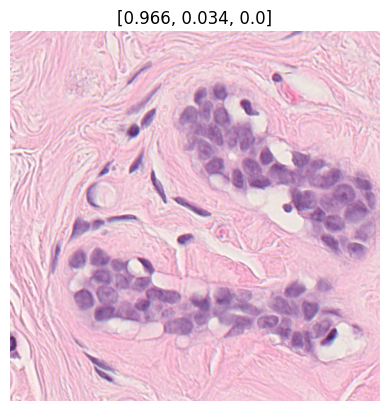

In [45]:
cond = (patch_df['cls'] == 'epithelium') & (patch_df['TC_epi'] > 0.95)
high = patch_df.loc[cond, :].sample(n=1).to_numpy()[0]
patch_id = high[1]

img_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch.png'
img = show_patch(wsi, patch_id, save_pt = img_pt)
plt.title(f"{[np.round(i, 3) for i in high[3:6]]}")
plt.axis('off')

[0.95 0.05 0.  ]
(16, 16)
(512, 512, 3)


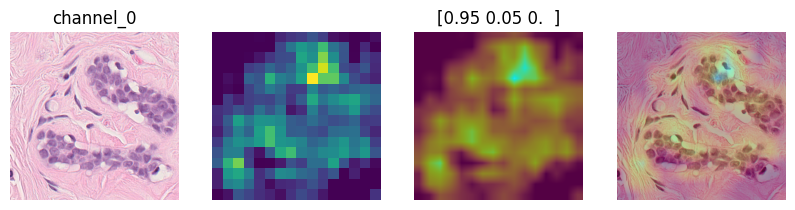

In [48]:
channel = 0
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= img_pt, 
                                                            model = TC_512, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

[0.95 0.05 0.  ]
(16, 16)
(512, 512, 3)


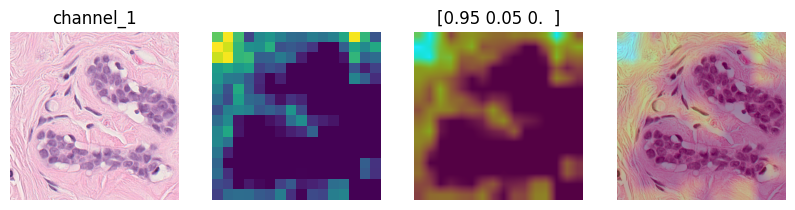

In [49]:
channel = 1
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= img_pt, 
                                                            model = TC_512, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

[0.95 0.05 0.  ]
(16, 16)
(512, 512, 3)


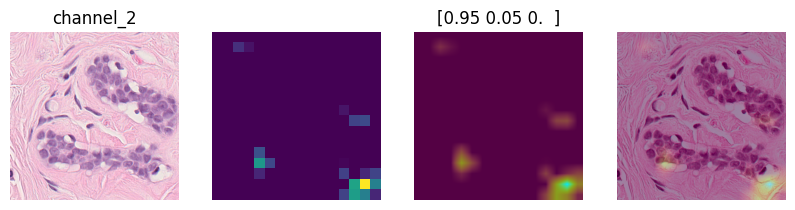

In [50]:
channel = 2
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= img_pt, 
                                                            model = TC_512, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

(-0.5, 578.5, 578.5, -0.5)

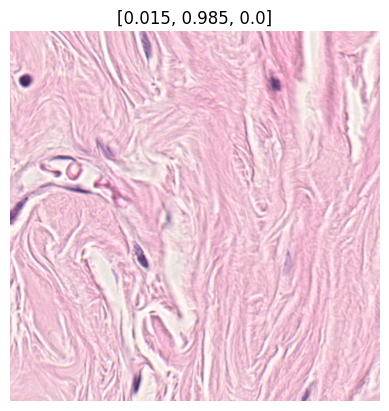

In [52]:
cond = (patch_df['cls'] == 'stroma') & (patch_df['TC_str'] > 0.95)
high = patch_df.loc[cond, :].sample(n=1).to_numpy()[0]
patch_id = high[1]

img_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch1.png'
img = show_patch(wsi, patch_id, save_pt = img_pt)
plt.title(f"{[np.round(i, 3) for i in high[3:6]]}")
plt.axis('off')

[0.02 0.98 0.  ]
(16, 16)
(512, 512, 3)


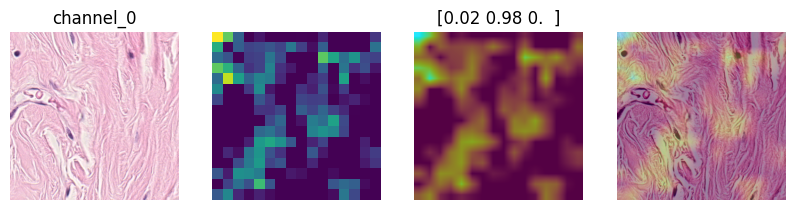

In [53]:
channel = 0
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= img_pt, 
                                                            model = TC_512, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

[0.02 0.98 0.  ]
(16, 16)
(512, 512, 3)


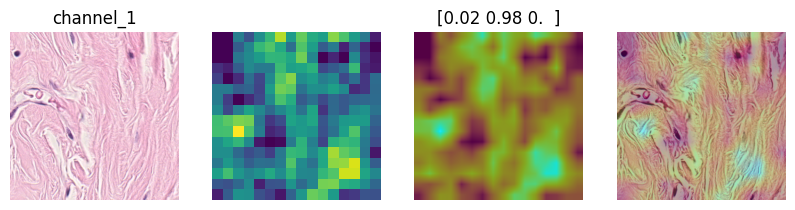

In [55]:
channel = 1
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= img_pt, 
                                                            model = TC_512, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

[0.02 0.98 0.  ]
(16, 16)
(512, 512, 3)


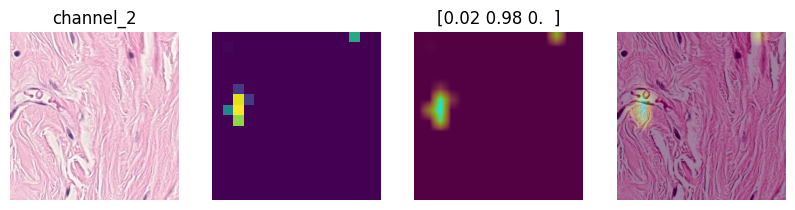

In [56]:
channel = 2
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= img_pt, 
                                                            model = TC_512, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

(-0.5, 578.5, 578.5, -0.5)

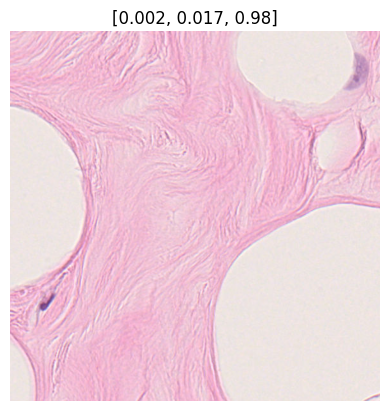

In [57]:
cond = (patch_df['cls'] == 'adipocytes') & (patch_df['TC_adi'] > 0.95)
high = patch_df.loc[cond, :].sample(n=1).to_numpy()[0]
patch_id = high[1]

img_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch2.png'
img = show_patch(wsi, patch_id, save_pt = img_pt)
plt.title(f"{[np.round(i, 3) for i in high[3:6]]}")
plt.axis('off')

[0.   0.02 0.98]
(16, 16)
(512, 512, 3)


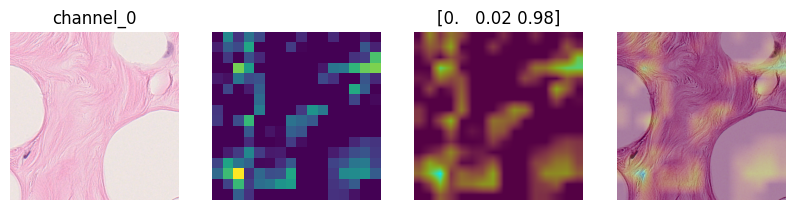

In [58]:
channel = 0
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= img_pt, 
                                                            model = TC_512, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

[0.   0.02 0.98]
(16, 16)
(512, 512, 3)


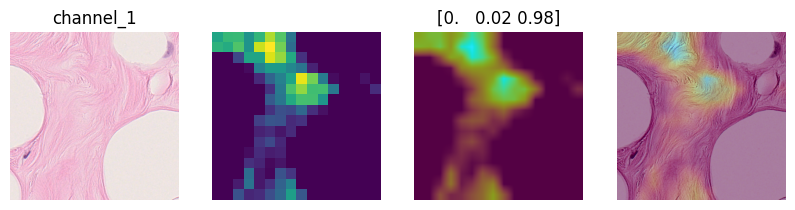

In [59]:
channel = 1
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= img_pt, 
                                                            model = TC_512, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

[0.   0.02 0.98]
(16, 16)
(512, 512, 3)


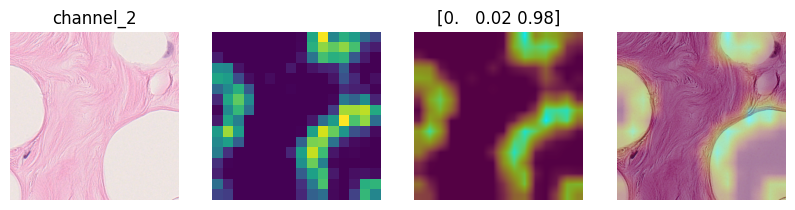

In [60]:
channel = 2
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= img_pt, 
                                                            model = TC_512, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

### grad-CAM

tf.Tensor([[9.0260327e-01 9.6731335e-02 6.6542206e-04]], shape=(1, 3), dtype=float32)
(512, 512, 3)


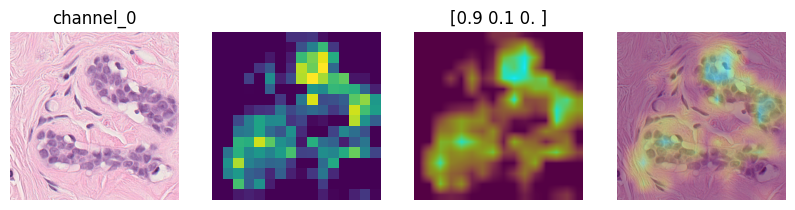

In [77]:
img_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch.png'
img = Image.open(img_pt)

channel = 0
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path=img_pt, model=TC_512, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','', preds[0], ''], figure_size=(10, 5))

tf.Tensor([[9.0260327e-01 9.6731335e-02 6.6542206e-04]], shape=(1, 3), dtype=float32)
(512, 512, 3)


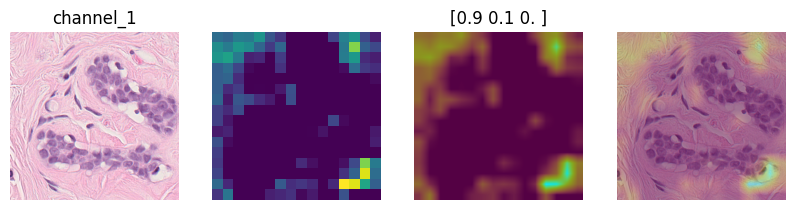

In [76]:
channel = 1
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path=img_pt, model=TC_512, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

tf.Tensor([[9.0260327e-01 9.6731335e-02 6.6542206e-04]], shape=(1, 3), dtype=float32)
(512, 512, 3)


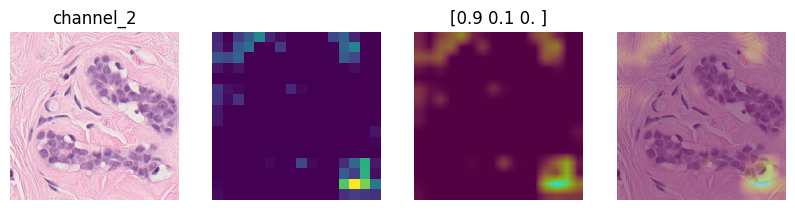

In [78]:
channel = 2
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path=img_pt, model=TC_512, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

tf.Tensor([[2.6003942e-02 9.7303128e-01 9.6477242e-04]], shape=(1, 3), dtype=float32)
(512, 512, 3)


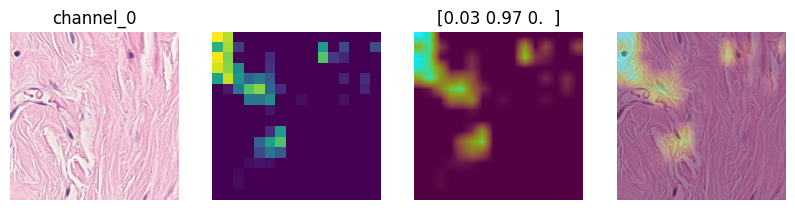

In [79]:
img_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch1.png'
img = Image.open(img_pt)

channel = 0
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path=img_pt, model=TC_512, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

tf.Tensor([[2.6003942e-02 9.7303128e-01 9.6477242e-04]], shape=(1, 3), dtype=float32)
(512, 512, 3)


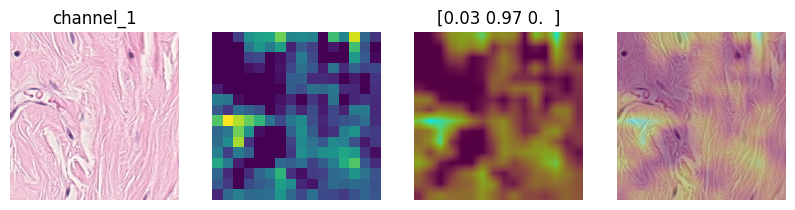

In [80]:
channel = 1
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path=img_pt, model=TC_512, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

tf.Tensor([[2.6003942e-02 9.7303128e-01 9.6477242e-04]], shape=(1, 3), dtype=float32)
(512, 512, 3)


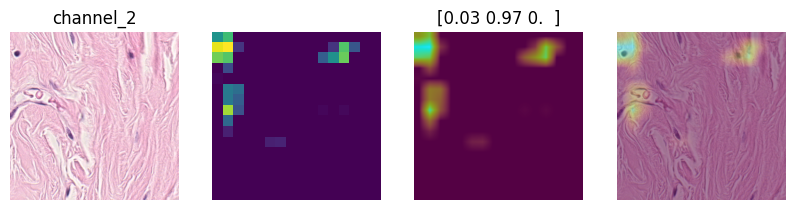

In [81]:
channel = 2
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path=img_pt, model=TC_512, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

tf.Tensor([[2.6386080e-05 7.5047935e-04 9.9922311e-01]], shape=(1, 3), dtype=float32)
(512, 512, 3)


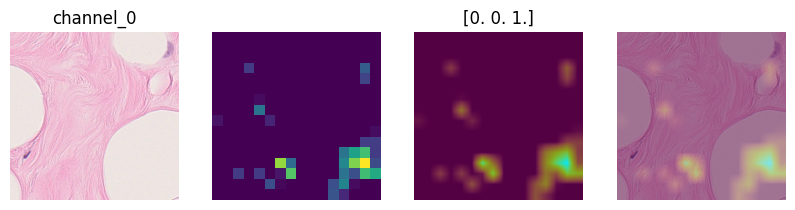

In [82]:
img_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch2.png'
img = Image.open(img_pt)

channel = 0
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path=img_pt, model=TC_512, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

tf.Tensor([[2.6386080e-05 7.5047935e-04 9.9922311e-01]], shape=(1, 3), dtype=float32)
(512, 512, 3)


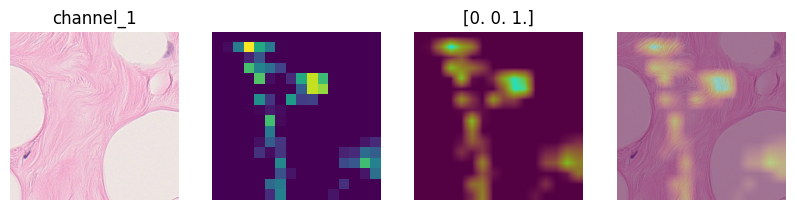

In [83]:
channel = 1
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path=img_pt, model=TC_512, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

tf.Tensor([[2.6386080e-05 7.5047935e-04 9.9922311e-01]], shape=(1, 3), dtype=float32)
(512, 512, 3)


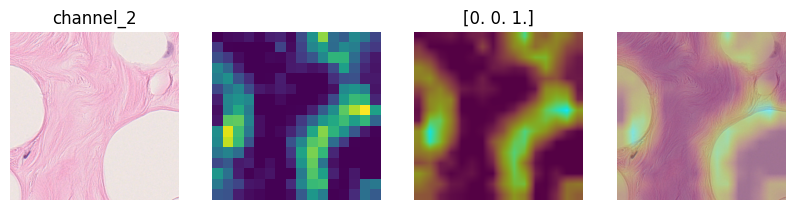

In [84]:
channel = 2
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path=img_pt, model=TC_512, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

### Alternatively, using TC_1024

In [36]:
TC_1024 = get_TC1024()
TC_1024.summary()

/scratch/users/k21066795/conda/tfgpu_env/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024, 1024, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, 512, 512, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 512, 512, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 512, 512, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 512, 512, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 512, 512, 32)      128 

(-0.5, 135.5, 96.5, -0.5)

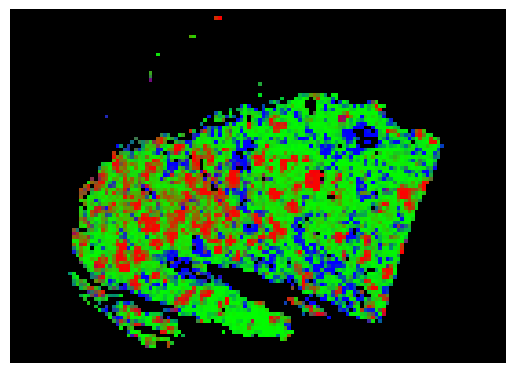

In [40]:
tissue_map = run_TC_one_slide(wsi, mask_pt, TC_1024, outputDir, patch_size=256, foreground_thes=0.7)            
np.save(outputDir + f'/{wsi_id}TC_1024Mask.npy', tissue_map)

tissue_map1024 = np.load(outputDir + f'/{wsi_id}TC_1024Mask.npy')
tissue_map2 = tissue_map1024.copy()
tissue_map2[:,:,1] = tissue_map1024[:,:,2]
tissue_map2[:,:,2] = tissue_map1024[:,:,1]
plt.imshow(tissue_map2)
plt.axis('off')

### export json file to visualise TC1024 results in QuPath

In [41]:
TC_pred = tissue_map2
TC_cls = np.argmax(TC_pred, axis=2)
TC_cls[TC_pred[:,:,0]==0] = 3

cls_dict = {'epithelium': 0, 'stroma':1, 'adipocytes':2, 'background': 3}
json_pt = f"{outputDir}/{wsi_id}_TC1024.json"
patch_size, _ = parse_patch_size(wsi, patch_size=256)
print(patch_size)

TC1024_json = get_json_from_map(TC_cls, cls_dict, json_pt, patch_size, require_bounds=False)

1158
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/17064108_FPE_1_TC1024.json saved!


In [ ]:
# wsi = openslide.OpenSlide(wsi_pt)
# wsi_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17064108_FPE_1.ndpi'
# img = wsi.read_region((0,0), 5, wsi.level_dimensions[5]).convert('RGB')
# gray_image = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
# ret2,th2 = cv2.threshold(gray_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plt.imshow(255-th2, cmap='gray')
# plt.axis('off')
# plt.savefig("/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/17064108_Ostu.png", pad_inches=0, bbox_inches="tight")


# wsi_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/SGK_healthy/K108219.svs'
# fmask_pt =  glob.glob(f'/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSI_QC/SGK_healthy/K108219.svs/*_mask_use.png')[0]
# mask_pt = glob.glob(f'/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K108219/*TC*.png')[0]
# TC_maskpt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/SGK_healthy/K108219/K108219_TCprobmask.npy'
# outputDir = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp'

# im = Image.open(fmask_pt)
# plt.imshow(im, cmap='gray')
# plt.axis('off')
# plt.savefig(outputDir+'/WSI_mask.png', bbox_inches='tight', pad_inches=0)

# im = Image.open(mask_pt)
# plt.imshow(im)
# plt.axis('off')
# plt.savefig(outputDir+'/WSI_TCmask.png', bbox_inches='tight', pad_inches=0)

# # images = glob.glob(f'/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/EPFL/H*.vsi')
# # index = np.random.randint(len(images))
# # wsi_pt = images[index]
# wsi = openslide.OpenSlide(wsi_pt)
# im_wsi = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
# plt.imshow(im_wsi)
# plt.axis('off')
# plt.savefig(outputDir+'/WSI.png', bbox_inches='tight', pad_inches=0)